In [2]:
from google.colab import drive

# Mount Google Drive to access saved model and data
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import joblib

# Correct model and test dataset paths
model_path = '/content/drive/MyDrive/IDS data sets/Naive_Base.joblib'  # model path
test_data_path = '/content/drive/MyDrive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv'  # test data path
train_data_path = '/content/drive/MyDrive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_train.csv'  # train data path


# Load the model using joblib
Naive_base = joblib.load(model_path)

# Load the test dataset
test_data = pd.read_csv(test_data_path)
train_data = pd.read_csv(train_data_path)

In [4]:
X_train = train_data.drop(columns=['Attack'])
y_train = train_data['Attack']

X_test = test_data.drop(columns=['Attack'])
y_test = test_data['Attack']

In [5]:
# Get the feature names used during training
training_features = Naive_base.feature_names_in_

# Select only the common features from the test data
X_test = X_test[training_features]

# Now, make predictions using the aligned test data
y_pred = Naive_base.predict(X_test)

# Print predictions to verify
print(f'The Prediction for index 698 is: {y_pred[698]}, and y_test is: {y_test[698]}')

The Prediction for index 698 is: DDoS, and y_test is: DDoS


In [6]:
class_names = y_train.unique()  # Get unique values from the target variable
class_names

array(['DoS', 'DDoS', 'Reconnaissance', 'Benign', 'Theft'], dtype=object)

In [7]:
# Display the number of NaN values per column in X_train and X_test
print("NaN values in each column of X_train:")
print(X_train.isna().sum())

print("\nNaN values in each column of X_test:")
print(X_test.isna().sum())

# Drop columns with any NaN values from X_train and X_test
X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)

NaN values in each column of X_train:
L4_SRC_PORT                       0
L4_DST_PORT                       0
PROTOCOL                          0
L7_PROTO                          0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYTES                         0
OUT_PKTS                          0
TCP_FLAGS                         0
CLIENT_TCP_FLAGS                  0
SERVER_TCP_FLAGS                  0
FLOW_DURATION_MILLISECONDS        0
DURATION_IN                       0
DURATION_OUT                      0
MIN_TTL                           0
MAX_TTL                           0
LONGEST_FLOW_PKT                  0
SHORTEST_FLOW_PKT                 0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
SRC_TO_DST_SECOND_BYTES           0
DST_TO_SRC_SECOND_BYTES           0
RETRANSMITTED_IN_BYTES            0
RETRANSMITTED_IN_PKTS             0
RETRANSMITTED_OUT_BYTES           0
RETRANSMITTED_OUT_PKTS            0
SRC_TO_DST_AVG_THROUGHPUT 

In [8]:
import shap

# Calculate SHAP values
#explainer = shap.KernelExplainer(Naive_base.predict_proba, X_train , random_state=42)
#shap_values = explainer.shap_values(X_test)


import shap

# Initialize SHAP KernelExplainer using a sample of the training data to create a background distribution
# This is essential to make the SHAP explanations accurate for the Naive Bayes model
explainer = shap.KernelExplainer(Naive_base.predict_proba, X_train.sample(500, random_state=42))

# Calculate SHAP values for a sample of the test set to keep computation manageable
shap_values = explainer.shap_values(X_test.iloc[:100])  # adjust 50 to desired sample size



  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_

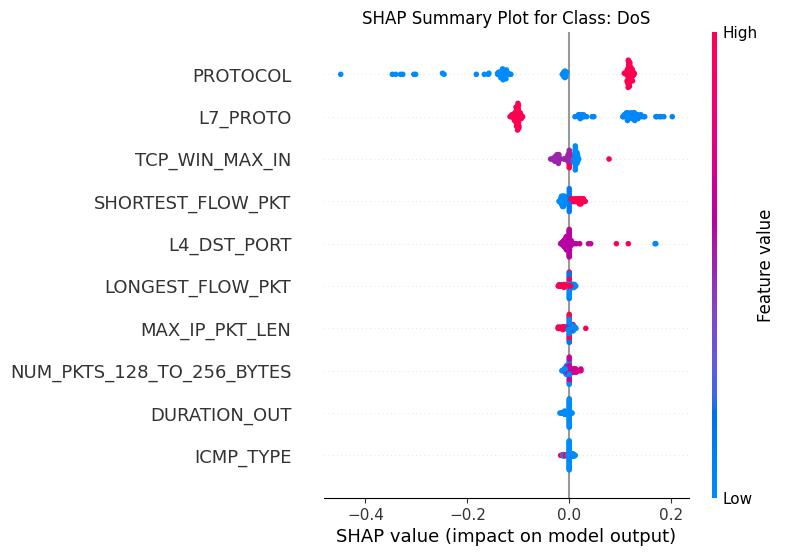

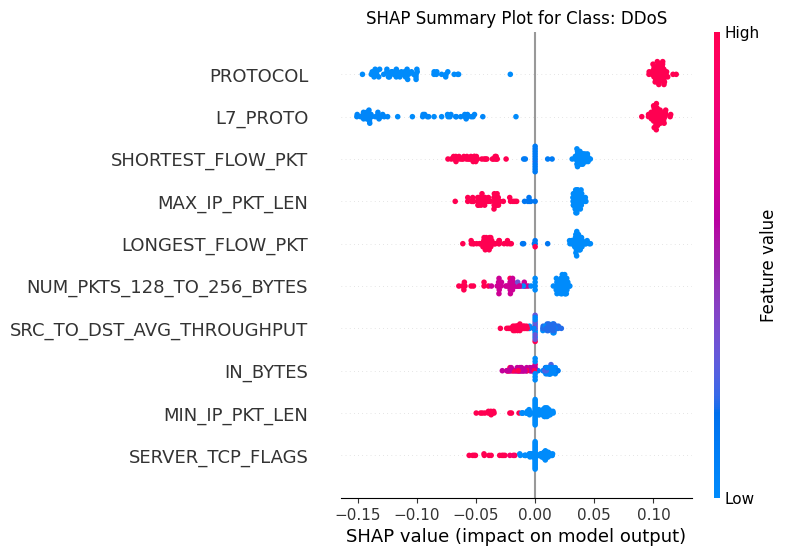

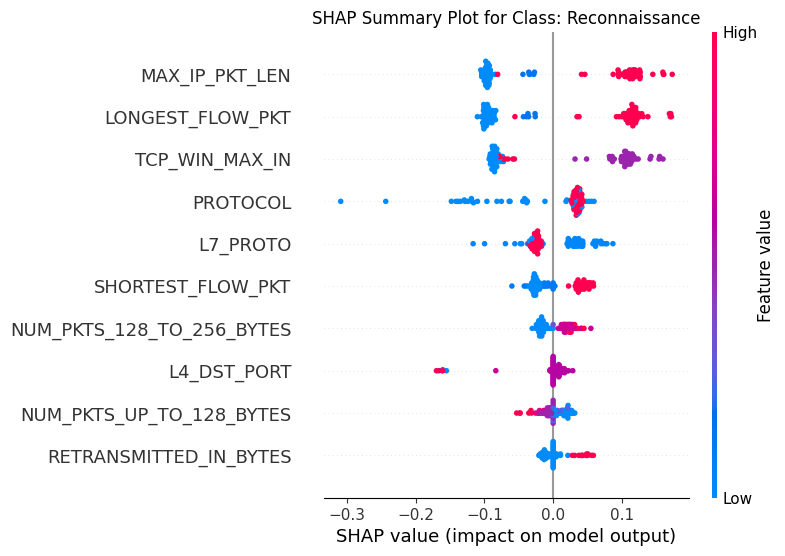

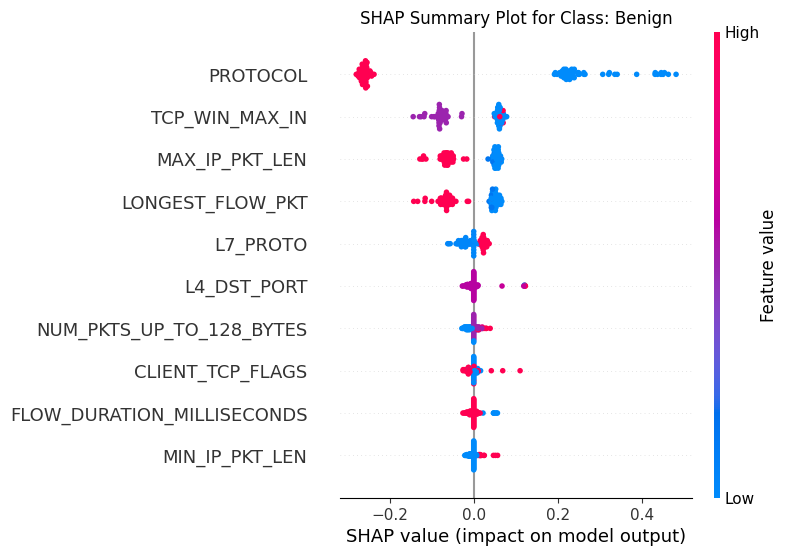

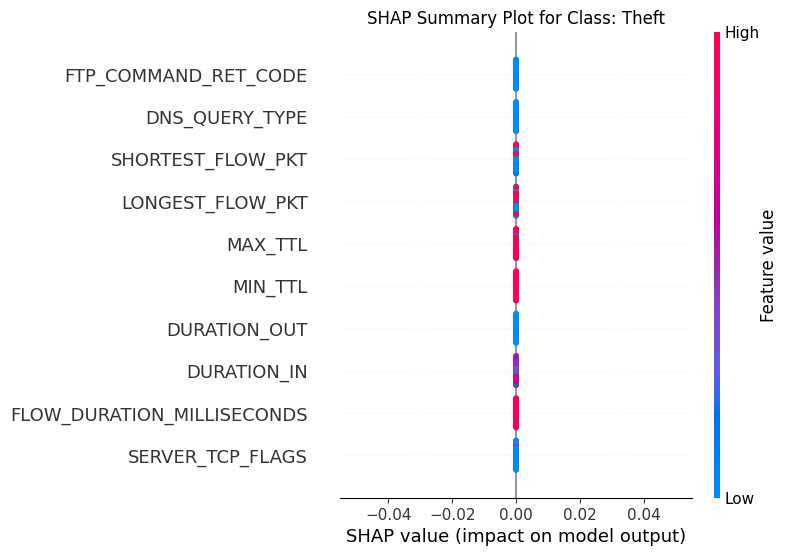

In [9]:
import matplotlib.pyplot as plt

# Plotting with adjusted figure size
num_classes = shap_values.shape[2]
for class_index in range(num_classes):
    shap_values_class = shap_values[:, :, class_index]

    # Set figure size before plotting
    plt.figure(figsize=(10, 6))  # Adjust width and height as needed

    # Use the same subset of X_test that was used for SHAP calculation
    X_test_subset = X_test.iloc[:100]

    shap.summary_plot(shap_values_class, X_test_subset, feature_names=X_test_subset.columns,
                      max_display=10, show=False)
    class_name = class_names[class_index]
    plt.title(f"SHAP Summary Plot for Class: {class_name}")

In [10]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3d5cf5894195ce019140588c0f7a08fbab66fa8d918b689599acab7d84cb50df
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [11]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Use training data for LIME
    feature_names=training_features,
    class_names=Naive_base.classes_,  # Get class names from the model
    mode="classification",
)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

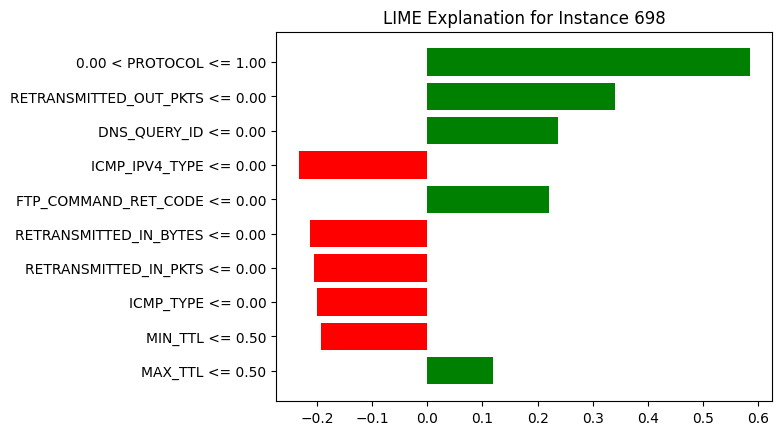

In [13]:
# Choose an instance to explain (for example, the first instance)
instance_to_explain = X_test.iloc[698]

# Generate LIME explanation
lime_exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=Naive_base.predict_proba,
)

# Plot LIME explanation for the selected instance
lime_exp.as_pyplot_figure()
plt.title('LIME Explanation for Instance 698')
plt.show()